In [1]:
usePickle = True # set to False to use trajectories

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import pickle
import math
import time
if not usePickle:
    import lammps_logfile
from scipy.constants import k as kB

In [3]:
def autocorr2(x): # autocorrelation function
    r2=np.fft.ifft(np.abs(np.fft.fft(x))**2).real
    c=(r2/x.shape-np.mean(x)**2)/np.std(x)**2
    return c[:len(x)//2]

In [4]:
@numba.njit(fastmath=True)
def block_bootstrap(data,nb): # nb: elements per block; NB: number of blocks
    
    avg = np.mean(data)
    var = np.var(data) 

    ndata = len(data)
    NB = len(data)//nb
    if ndata%nb != 0:
        leftout = [-i for i in range(1,ndata-NB*nb+1)]
        data = np.delete(data,leftout)

    # error of average and variance using block bootstrap
    B = 200
    bootstrap_avgs = np.zeros(B)
    bootstrap_vars = np.zeros(B)
    for i in range(B):
        bootstrap_blocks = np.reshape(data,(NB,-1))[np.random.choice(NB,NB)].flatten()
        bootstrap_avgs[i] = np.mean(bootstrap_blocks)
        bootstrap_vars[i] = np.var(bootstrap_blocks)      
    err_avg = np.std(bootstrap_avgs)*np.sqrt(B)/np.sqrt(B-1)
    err_var = np.std(bootstrap_vars)*np.sqrt(B)/np.sqrt(B-1)
               
    return avg, err_avg, var, err_var

# Figures 1(a), 1(b) 
### (LJ in SimpleMD: average and variance of the volume as functions of $\tau_p$)

In [5]:
tps = np.array([0.1,0.2,0.5,1.0,2.0,5.0,10.0,20.0,50.0,100.0]) # tau_p values employed

Loading data:

In [6]:
if not usePickle:
    ene={}
    for tp in tps:
        ene['EULER',tp]=np.loadtxt("LJ_SimpleMD/variable_taup/energies_brF_bsvT_" + str(tp) + ".dat")
        ene['TR',tp]=np.loadtxt("LJ_SimpleMD/variable_taup/energies_TR_brF_bsvT_" + str(tp) + ".dat")
        ene['ISO',tp]=np.loadtxt("LJ_SimpleMD/variable_taup/energies_iso_bsvT_" + str(tp) + ".dat")
        print(ene['EULER',tp].shape, ene['TR',tp].shape,ene['ISO',tp].shape)

Block-bootstrap analysis:

In [7]:
if not usePickle:
    nbs = np.logspace(math.log(3,10), math.log(30001,10), num=50,dtype=int)[1:]
    print("\nLength of blocks n_b employed in block analysis:\n" + str(nbs))

In [8]:
if not usePickle:
    start_time = time.time()
    start = 10**5
    plt_values = {}
    errors = {}
    plt_errors = {}
    keys = ['avg','var']
    barostats = ['EULER','TR','ISO']
    for key in keys:
        for baro in barostats:
            plt_values[baro,key] = []
            plt_errors[baro,key] = []
            for tp in tps:
                errors[baro,key,tp] = []
    for tp in tps:
        for baro in barostats:
            for iblock in range(len(nbs)):
                avg, err_avg, var, err_var = block_bootstrap(np.array(ene[baro,tp][start:,5]),nbs[iblock])
                errors[baro,'avg',tp].append(err_avg)
                errors[baro,'var',tp].append(err_var)
            plt_values[baro,'avg'].append(avg)
            plt_values[baro,'var'].append(var)

    for tp in tps:
        for case in keys:
            for baro in barostats:
                plt_errors[baro,case].append(max(errors[baro,case,tp]))
    end_time = time.time()
    print("Execution time: "+ str(end_time - start_time))
    
    #pickle.dump([plt_values,plt_errors],open("plt_LJ_SimpleMD_taup.p","wb"))

In [9]:
if usePickle:
    plt_values,plt_errors=pickle.load(open("plt_LJ_SimpleMD_taup.p","rb"))

#### Figure 1(a)

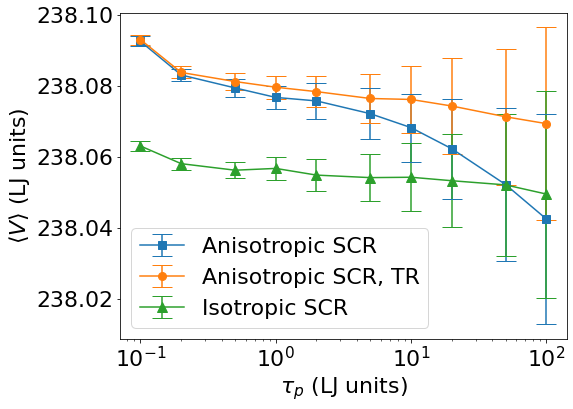

In [10]:
plt.rcParams.update({'font.size': 22})
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(1,1,1)
plt.errorbar(tps,plt_values['EULER','avg'],plt_errors['EULER','avg'],fmt='s-',markersize=8,capsize=10,label='Anisotropic SCR')
plt.errorbar(tps,plt_values['TR','avg'],plt_errors['TR','avg'],fmt='o-',markersize=8,capsize=10,label='Anisotropic SCR, TR')
plt.errorbar(tps,plt_values['ISO','avg'],plt_errors['ISO','avg'],fmt='^-',markersize=10,capsize=10,label='Isotropic SCR')
plt.xscale('log')
plt.xlabel('$\\tau_p$ (LJ units)')
plt.ylabel('$\\langle V \\rangle$ (LJ units)')
plt.ticklabel_format(useOffset=False, style='plain',axis='y')
plt.legend()
#plt.savefig("fig_avgs_simplemd_taup.pdf", dpi=300, bbox_inches="tight")
plt.show()

#### Figure 1(b)

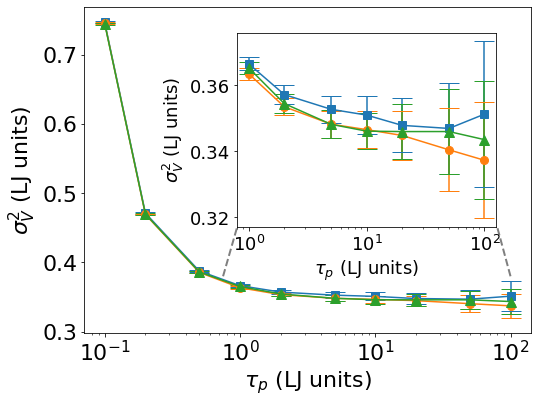

In [11]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(figsize=(8,6))
left, bottom, width, height = [0.39, 0.37, 0.45, 0.45]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.errorbar(tps,plt_values['EULER','var'],plt_errors['EULER','var'],fmt='s-',capsize=10,markersize=8,label='Anisotropic SCR')
ax1.errorbar(tps,plt_values['TR','var'],plt_errors['TR','var'],fmt='o-',capsize=10,markersize=8,label='Anisotropic SCR, TR')
ax1.errorbar(tps,plt_values['ISO','var'],plt_errors['ISO','var'],fmt='^-',capsize=10,markersize=10,label='Isotropic SCR')
ax1.plot(np.linspace(0.75,0.95,2),np.linspace(0.38,0.45,2),'k--',linewidth=2.,alpha=0.5)
ax1.plot(np.linspace(100,80,2),np.linspace(0.38,0.45,2),'k--',linewidth=2.,alpha=0.5)                   
ax2.errorbar(tps[3:],plt_values['EULER','var'][3:],plt_errors['EULER','var'][3:],fmt='s-',capsize=10,markersize=8,label='Anisotropic SCR')
ax2.errorbar(tps[3:],plt_values['TR','var'][3:],plt_errors['TR','var'][3:],fmt='o-',capsize=10,markersize=8,label='Anisotropic SCR, TR')
ax2.errorbar(tps[3:],plt_values['ISO','var'][3:],plt_errors['ISO','var'][3:],fmt='^-',capsize=10,markersize=10,label='Isotropic SCR')
ax1.set(xscale='log',xlabel='$\\tau_p$ (LJ units)',ylabel='$\\sigma_V^2$ (LJ units)')
ax2.set(xscale='log',xlabel='$\\tau_p$ (LJ units)',ylabel='$\\sigma_V^2$ (LJ units)')
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels() ):
    item.set_fontsize(18)
#plt.savefig("fig_vars_simplemd_taup.pdf", dpi=300, bbox_inches="tight")

# Figure 2(a)
### (LJ in SimpleMD: effective energy drift as a function of $\tau_p$)

In [12]:
if not usePickle:
    start=10**5
    eff_energy= {}
    times = ene['ISO',tps[0]][start:,1]
    for tp in tps:
        eff_energy['ISO',tp] = ene['ISO',tp][start:,4]
        eff_energy['TR',tp] = ene['TR',tp][start:,4]

Linear fit of effective energy trajectories:

In [13]:
if not usePickle:
    start=10**5
    slopes_iso = []
    slopes_aniso = []
    for tp in tps:
        slopes_iso.append(np.polyfit(times,eff_energy['ISO',tp],1)[0])
        slopes_aniso.append(np.polyfit(times,eff_energy['TR',tp],1)[0])
    #pickle.dump([slopes_iso,slopes_aniso],open("LJ_SimpleMD_effenergy_taup.p","wb"))
else:
    slopes_iso, slopes_aniso = pickle.load(open("LJ_SimpleMD_effenergy_taup.p","rb"))

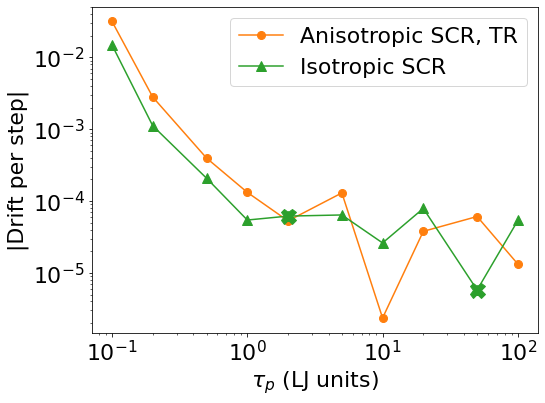

In [14]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 22})
plt.plot(tps,np.abs(slopes_aniso),"o-",markersize=8,color="tab:orange",label='Anisotropic SCR, TR')
plt.plot(tps,np.abs(slopes_iso),"^-",markersize=10,color="tab:green",label='Isotropic SCR')
plt.plot(tps[4],np.abs(slopes_iso[4]),"X",markersize=15,color="tab:green")
plt.plot(tps[8],np.abs(slopes_iso[8]),"X",markersize=15,color="tab:green")
plt.xlabel("$\\tau_p$ (LJ units)")
plt.ylabel("|Drift per step|")
plt.yscale("log")
plt.xscale("log")
plt.legend()
#plt.savefig("fig_drift_taup.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Figures 1(c), 1(d)
### (LJ in SimpleMD: average and variance of the volume as functions of barostat stride)

In [15]:
nsts = np.array([1,2,5,10,20,50,100]) # tau_p values employed

Loading data:

In [16]:
if not usePickle:
    ene={}
    for nst in nsts:
        ene['EULER',nst]=np.loadtxt("LJ_SimpleMD/variable_ns/energies_brF_bsvT_" + str(nst) + ".dat")
        ene['TR',nst]=np.loadtxt("LJ_SimpleMD/variable_ns/energies_TR_brF_bsvT_" + str(nst) + ".dat")
        ene['ISO',nst]=np.loadtxt("LJ_SimpleMD/variable_ns/energies_iso_brF_bsvT_" + str(nst) + ".dat")
        print(ene['EULER',nst].shape,ene['TR',nst].shape,ene['ISO',nst].shape)

Block-bootstrap analysis:

In [17]:
if not usePickle:
    nbs = np.logspace(math.log(3,10), math.log(18001,10), num=50,dtype=int)[1:]
    print("\nLength of blocks n_b employed in block analysis:\n" + str(nbs))

In [18]:
if not usePickle:

    start_time = time.time()
    start = 10**5
    plt_values = {}
    errors = {}
    plt_errors = {}
    keys = ['avg','var']
    barostats = ['EULER','TR','ISO']
    for key in keys:
        for baro in barostats:
            plt_values[baro,key] = []
            plt_errors[baro,key] = []
            for nst in nsts:
                errors[baro,key,nst] = []
    for nst in nsts:
        for baro in barostats:
            for iblock in range(len(nbs)):
                avg, err_avg, var, err_var = block_bootstrap(np.array(ene[baro,nst][start:,5]),nbs[iblock])
                errors[baro,'avg',nst].append(err_avg)
                errors[baro,'var',nst].append(err_var)
            plt_values[baro,'avg'].append(avg)
            plt_values[baro,'var'].append(var)
    for nst in nsts:
        for case in keys:
            for baro in barostats:
                plt_errors[baro,case].append(max(errors[baro,case,nst]))
    end_time = time.time()
    print("Execution time: "+ str(end_time - start_time))
    
    #pickle.dump([plt_values,plt_errors],open("plt_LJ_SimpleMD_ns.p","wb"))

In [19]:
if usePickle:
    plt_values,plt_errors=pickle.load(open("plt_LJ_SimpleMD_ns.p","rb"))

#### Figure 1(c)

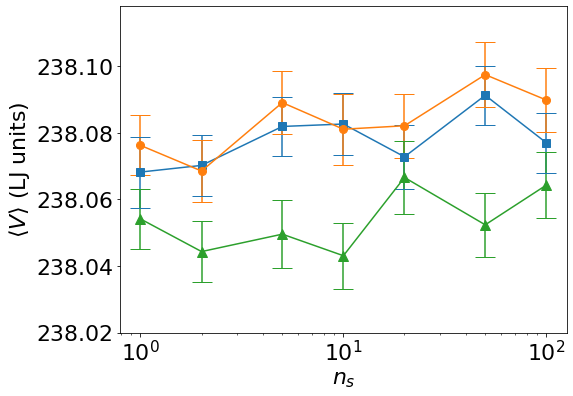

In [20]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(8,6))

plt.errorbar(nsts,plt_values['EULER','avg'],plt_errors['EULER','avg'],fmt='s-',capsize=10,markersize=8,label='Anisotropic SCR')
plt.errorbar(nsts,plt_values['TR','avg'],plt_errors['TR','avg'],fmt='o-',capsize=10,markersize=8,label='Anisotropic SCR, TR')
plt.errorbar(nsts,plt_values['ISO','avg'],plt_errors['ISO','avg'],fmt='^-',capsize=10,markersize=10,label='Isotropic SCR')
plt.xscale('log')
plt.ylim([238.02,238.118])
plt.xlabel('$n_s$')
plt.ylabel('$\\langle V \\rangle$ (LJ units)')
#plt.savefig("fig_avgs_simplemd_ns.pdf", dpi=300, bbox_inches="tight")

plt.show()

#### Figure 1(d)

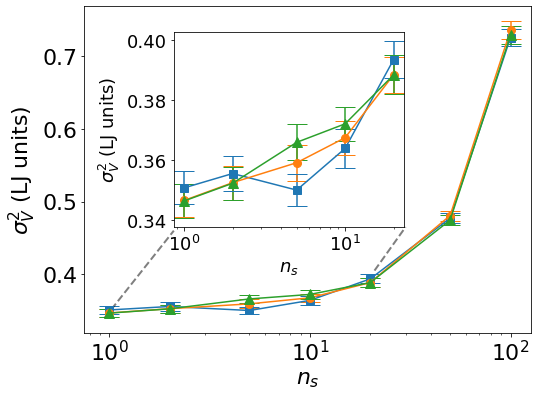

In [21]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(figsize=(8,6))
left, bottom, width, height = [0.28, 0.37, 0.4, 0.45]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.errorbar(nsts,plt_values['EULER','var'],plt_errors['EULER','var'],fmt='s-',markersize=8,capsize=10,label='Anisotropic SCR')
ax1.errorbar(nsts,plt_values['TR','var'],plt_errors['TR','var'],fmt='o-',markersize=8,capsize=10,label='Anisotropic SCR, TR')
ax1.errorbar(nsts,plt_values['ISO','var'],plt_errors['ISO','var'],fmt='^-',markersize=10,capsize=10,label='Isotropic SCR')

ax2.errorbar(nsts[0:5],plt_values['EULER','var'][0:5],plt_errors['EULER','var'][0:5],fmt='s-',markersize=8,capsize=10,label='Anisotropic SCR')
ax2.errorbar(nsts[0:5],plt_values['TR','var'][0:5],plt_errors['TR','var'][0:5],fmt='o-',markersize=8,capsize=10,label='Anisotropic SCR, TR')
ax2.errorbar(nsts[0:5],plt_values['ISO','var'][0:5],plt_errors['ISO','var'][0:5],fmt='^-',markersize=10,capsize=10,label='Isotropic SCR')

ax1.plot(np.linspace(0.95,2.1,2),np.linspace(0.34,0.46,2),'k--',linewidth=2.,alpha=0.5)
ax1.plot(np.linspace(21,30,2),np.linspace(0.405,0.465,2),'k--',linewidth=2.,alpha=0.5)  
ax1.set(xscale='log',xlabel='$n_s$',ylabel='$\\sigma_V^2$ (LJ units)')
ax2.set(xscale='log',xlabel='$n_s$',ylabel='$\\sigma_V^2$ (LJ units)')
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(18)
#plt.savefig("fig_vars_simplemd_ns.pdf", dpi=300, bbox_inches="tight")
plt.show()

## Figure 2(b)
### (LJ in SimpleMD: effective energy drift as a function of the barostat stride)

In [22]:
if not usePickle:
    start=3*10**5
    eff_energy= {}
    times = ene['ISO',nsts[0]][start:,1]
    for nst in nsts:
        eff_energy['ISO',nst] = ene['ISO',nst][start:,4]
        eff_energy['TR',nst] = ene['TR',nst][start:,4]

Linear fit of effective energy trajectories:

In [23]:
if not usePickle:
    slopes_iso = []
    slopes_aniso = []
    for nst in nsts:
        slopes_iso.append(np.polyfit(times,eff_energy['ISO',nst],1)[0])
        slopes_aniso.append(np.polyfit(times,eff_energy['TR',nst],1)[0])
    pickle.dump([slopes_iso,slopes_aniso],open("LJ_SimpleMD_effenergy_ns.p","wb"))
else:
    slopes_iso,slopes_aniso = pickle.load(open("LJ_SimpleMD_effenergy_ns.p","rb"))

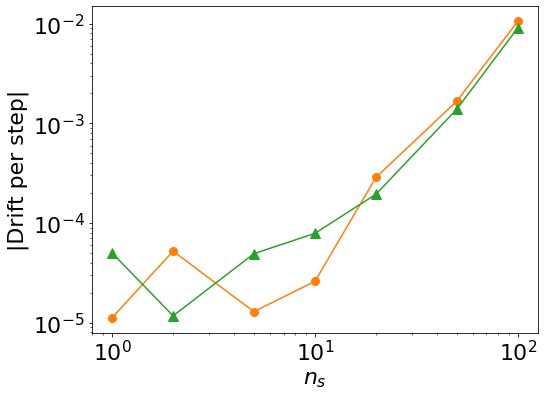

In [24]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 22})

plt.plot(nsts,np.abs(slopes_aniso),"o-",markersize=8,color="tab:orange",label='Anisotropic SCR, TR')
plt.plot(nsts,np.abs(slopes_iso),"^-",markersize=10,color="tab:green",label='Isotropic SCR')

plt.xlabel("$n_s$")
plt.ylabel("|Drift per step|")
plt.yscale("log")
plt.xscale("log")
#plt.savefig("fig_drift_ns.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Figures 3(a),  3(b),  3(c),  3(d),  3(e),  3(f) 
### (LJ in GROMACS: average and variance of the volume as functions of $\tau_p$)

In [25]:
tau_ps = [0.1,0.2,0.5,1,2,5,10,20,50,100] # tau_p values employed

Loading data:

In [27]:
volume = {}
if not usePickle:
    print("Iso\t Aniso\t IsoPR AnisoPR IsoMTTK")

    times = np.loadtxt("LJ_GROMACS/volume_iso_tp_0.1.xvg",comments=['#','@'])[:,0]
    for tau_p in tau_ps:
        volume['I',tau_p] = np.loadtxt("LJ_GROMACS/volume_iso_tp_" +str(tau_p)+".xvg",comments=['#','@'])[:,1]
        volume['A',tau_p] = np.loadtxt("LJ_GROMACS/volume_aniso_tp_" +str(tau_p)+".xvg",comments=['#','@'])[:,1]
        volume['IPR',tau_p] = np.loadtxt("LJ_GROMACS/volume_iso_PR_tp_" +str(tau_p)+".xvg",comments=['#','@'])[:,1]
        volume['APR',tau_p] = np.loadtxt("LJ_GROMACS/volume_aniso_PR_tp_" +str(tau_p)+".xvg",comments=['#','@'])[:,1]
        volume['IMTTK',tau_p] = np.loadtxt("LJ_GROMACS/volume_iso_MTTK_tp_" +str(tau_p)+".xvg",comments=['#','@'])[:,1]

        (print(str(len(volume['I',tau_p]))+"\t"+str(len(volume['A',tau_p]))+"\t"+str(len(volume['IPR',tau_p]))+
             "\t"+str(len(volume['APR',tau_p]))+"\t"+str(len(volume['IMTTK',tau_p]))))
        
    #tau_p = tau_ps[5]
    #pickle.dump([times,volume['I',tau_p],volume['A',tau_p],volume['IPR',tau_p],volume['APR',tau_p],
    #             volume['IMTTK',tau_p]],open("plt_LJ_GROMACS_trajectories.p","wb"))
    
else:
    tau_p = tau_ps[5]
    times,volume['I',tau_p],volume['A',tau_p],volume['IPR',tau_p],volume['APR',tau_p],volume['IMTTK',tau_p] = pickle.load(open("plt_LJ_GROMACS_trajectories.p","rb"))

#### Figures 3(e), 3(f): non-stationary distributions from PR simulations

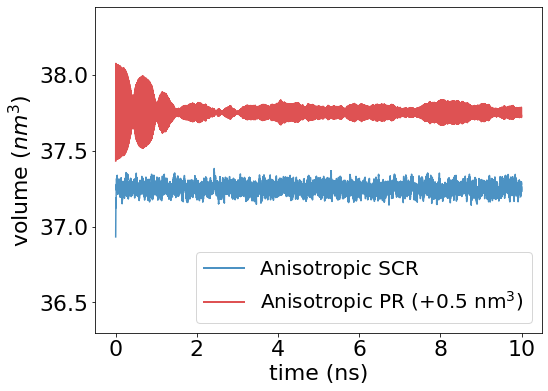

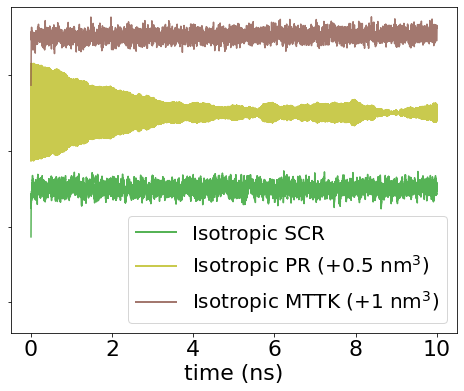

In [28]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(8,6))
tp = tau_ps[5]
plt.plot(times/1000,volume['A',tp],color='tab:blue',label='Anisotropic SCR',alpha=0.8)
plt.plot(times/1000,volume['APR',tp]+0.5,color='tab:red',label='Anisotropic PR ($+0.5$ nm$^3$)',alpha=0.8)
plt.xlabel("time (ns)")
plt.ylabel("volume ($nm^3$)")
leg = plt.legend(fontsize =20,loc="lower right")
plt.ylim(36.3,38.45)
for legobj in leg.legendHandles: legobj.set_linewidth(2.0)
plt.savefig("fig_pathological_aniso.pdf", dpi=300, bbox_inches="tight") 
plt.show()

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(8,6))
tp = tau_ps[5]
colors = ['tab:green','tab:olive','tab:brown']
plt.plot(times/1000,volume['I',tp],label="Isotropic SCR",color=colors[0],alpha=0.8)
plt.plot(times/1000,volume['IPR',tp]+0.5,label="Isotropic PR ($+0.5$ nm$^3$)",color=colors[1],alpha=0.8)
plt.plot(times/1000,volume['IMTTK',tp]+1.0,label="Isotropic MTTK ($+1$ nm$^3$)",color=colors[2],alpha=0.8)
plt.xlabel("time (ns)")
plt.ylim(36.3,38.45)
leg = plt.legend(fontsize =20,loc="lower right")
for legobj in leg.legendHandles: legobj.set_linewidth(2.0)
plt.gca().axes.yaxis.set_ticklabels([])
#plt.savefig("fig_pathological_iso.pdf", dpi=300, bbox_inches="tight") 
plt.show()

Block-bootstrap analysis:

In [29]:
if not usePickle:
    nbs = np.logspace(math.log(3,10), math.log(18001,10), num=50,dtype=int)[1:]
    print("\nLength of blocks n_b employed in block analysis:\n" + str(nbs))

In [30]:
if not usePickle:
    
    start_time = time.time()
    start=25000 
    plt_values = {}
    errors = {}
    plt_errors = {}
    keys = ['avg','var']
    barostats=['I','A','IPR','APR','IMTTK']
    for baro in barostats:
        for key in keys:
            for tp in tau_ps: 
                errors[baro,key,tp] = []
            plt_values[baro,key] = []
            plt_errors[baro,key] = []
    for baro in barostats:
        for tp in tau_ps:
            for iblock in range(len(nbs)): 
                avg, err_avg, var, err_var = block_bootstrap(np.array(volume[baro,tp][start:]),nbs[iblock])
                errors[baro,'avg',tp].append(err_avg)
                errors[baro,'var',tp].append(err_var)
            plt_values[baro,'avg'].append(avg) # NB independent on number of blocks
            plt_values[baro,'var'].append(var) 
    for baro in barostats:
        for key in keys:
            for tp in tau_ps:
                plt_errors[baro,key].append(max(errors[baro,key,tp]))
    end_time = time.time()
    print("Execution time: "+ str(end_time - start_time))
    
    #pickle.dump([plt_values,plt_errors],open("plt_LJ_GROMACS.p","wb"))

In [31]:
if usePickle:
    plt_values,plt_errors=pickle.load(open("plt_LJ_GROMACS.p","rb"))

#### Figure 3(a)

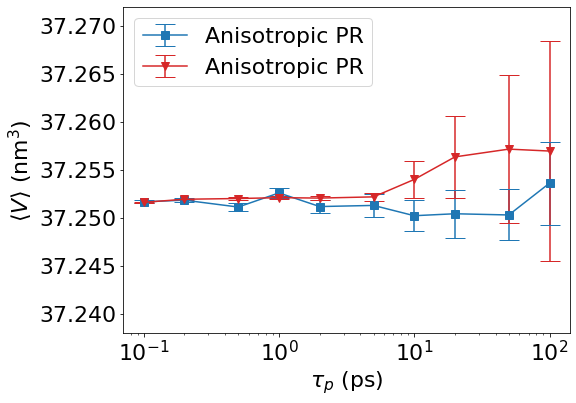

In [32]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(figsize=(8,6))
left, bottom, width, height = [0.25, 0.20, 0.5, 0.5]

labels = ['Anisotropic SCR','Anisotropic PR']
formats = ['s','v','*']
colors = ['tab:blue','tab:red','tab:brown']
markersizes = [8,10,10]
shifts = np.array([0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10])

ax1.errorbar(tau_ps,plt_values['A','avg'],plt_errors['A','avg'],fmt=formats[0]+'-',color=colors[0],capsize=10,markersize=markersizes[0],label=labels[1])
ax1.errorbar(tau_ps,plt_values['APR','avg'],plt_errors['APR','avg'],fmt=formats[1]+'-',color=colors[1],capsize=10,markersize=markersizes[0],label=labels[1])

ax1.set(xscale='log',xlabel='$\\tau_p$ (ps)',ylabel='$\\langle V \\rangle$ (nm$^3$)',ylim=[37.238,37.272])
ax1.legend()
#plt.savefig("fig_avgs_argon_aniso.pdf", dpi=300, bbox_inches="tight") 
plt.show()

#### Figure 3(b)

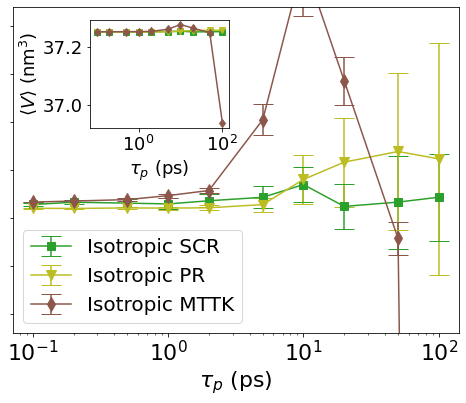

In [33]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(figsize=(8,6))
left, bottom, width, height = [0.26, 0.60, 0.24, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])

labels = ['Isotropic SCR', 'Isotropic PR','Isotropic MTTK']
formats = ['s','v','d']
colors = ['tab:green','tab:olive','tab:brown']
markersizes = [8,10,10]
shifts = np.array([0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10])

ax2.plot(tau_ps,plt_values['I','avg'],formats[0]+'-',markersize=6,label=labels[0],color=colors[0])
ax2.plot(tau_ps,plt_values['IPR','avg'],formats[1]+'-',markersize=6,label=labels[1],color=colors[1])
ax2.plot(tau_ps,plt_values['IMTTK','avg'],formats[2]+'-',markersize=6,label=labels[2],color=colors[2])

ax1.errorbar(tau_ps,plt_values['I','avg'],plt_errors['I','avg'],fmt=formats[0]+'-',color=colors[0],capsize=10,markersize=markersizes[0],label=labels[0])
ax1.errorbar(tau_ps,plt_values['IPR','avg'],plt_errors['IPR','avg'],fmt=formats[1]+'-',color=colors[1],capsize=10,markersize=markersizes[1],label=labels[1])
ax1.errorbar(tau_ps,plt_values['IMTTK','avg'],plt_errors['IMTTK','avg'],fmt=formats[2]+'-',color=colors[2],capsize=10,markersize=markersizes[2],label=labels[2])

ax1.set(xscale='log',xlabel='$\\tau_p$ (ps)',ylim=[37.238,37.272]) 
ax2.set(xscale='log',xlabel='$\\tau_p$ (ps)',ylabel='$\\langle V \\rangle$ (nm$^3$)')
ax1.axes.yaxis.set_ticklabels([])
ax1.legend(loc='lower left',fontsize=20)

for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] + ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(18)
#plt.savefig("fig_avgs_argon_iso.pdf", dpi=300, bbox_inches="tight") 
plt.show()

#### Figure 3(c)

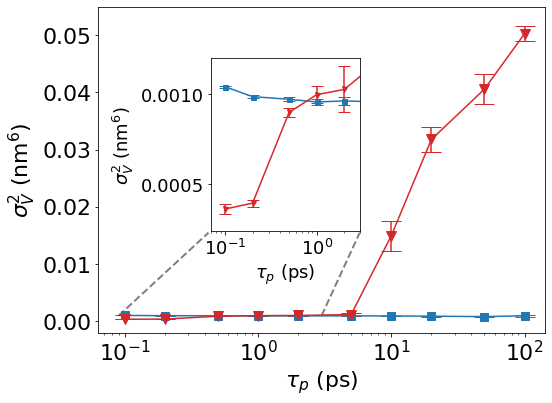

In [34]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(figsize=(8,6))
left, bottom, width, height = [0.32, 0.36, 0.26, 0.40]
ax2 = fig.add_axes([left, bottom, width, height])

labels = ['Anisotropic SCR','Anisotropic PR']
formats = ['s','v','d']
colors = ['tab:blue','tab:red']
markersizes = [8,10,10]
shifts = np.array([0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10])

ax1.errorbar(tau_ps,plt_values['A','var'],plt_errors['A','var'],fmt=formats[0]+'-',color=colors[0],capsize=10,markersize=markersizes[0],label=labels[0])
ax1.errorbar(tau_ps,plt_values['APR','var'],plt_errors['APR','var'],fmt=formats[1]+'-',color=colors[1],capsize=10,markersize=markersizes[1],label=labels[1])
ax2.errorbar(tau_ps[:6],plt_values['A','var'][:6],plt_errors['A','var'][:6],fmt=formats[0]+'-',color=colors[0],capsize=6,markersize=5,label=labels[0])
ax2.errorbar(tau_ps[:6],plt_values['APR','var'][:6],plt_errors['APR','var'][:6],fmt=formats[1]+'-',color=colors[1],capsize=6,markersize=5,label=labels[1])

ax1.set(xscale='log',xlabel='$\\tau_p$ (ps)',ylabel='$\\sigma_V^2 $ (nm$^6$)',ylim=[-0.002,0.055])
ax2.set(xscale='log',xlim=[0.07,3],ylim=[0.00024,0.0012],xlabel='$\\tau_p$ (ps)',ylabel='$\\sigma_V^2 $ (nm$^6$)')
ax1.plot(np.linspace(0.09,0.425,2),np.linspace(0.001,0.0155,2),'--',color='k',alpha=0.5,linewidth=2)
ax1.plot(np.linspace(3,5.8,2),np.linspace(0.001,0.0155,2),'--',color='k',alpha=0.5,linewidth=2)
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(18)
#plt.savefig("fig_vars_argon_aniso.pdf", dpi=300, bbox_inches="tight") 
plt.show()

#### Figure 3(d)

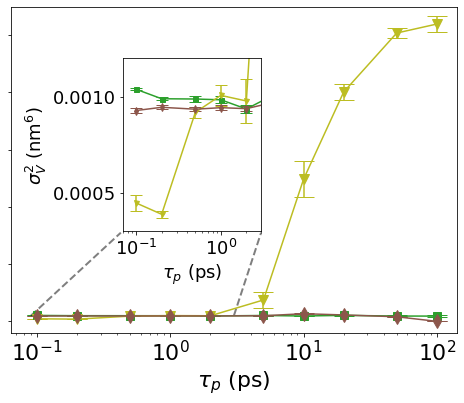

In [35]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(figsize=(8,6))
left, bottom, width, height = [0.32, 0.36, 0.24, 0.40]
ax2 = fig.add_axes([left, bottom, width, height])

labels = ['Isotropic SCR','Isotropic PR','Isotropic MTTK']
formats = ['s','v','d']
colors = ['tab:green','tab:olive','tab:brown']
markersizes = [8,10,10]
shifts = np.array([0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10])

ax1.errorbar(tau_ps,plt_values['I','var'],plt_errors['I','var'],fmt=formats[0]+'-',color=colors[0],capsize=10,markersize=markersizes[0],label=labels[0])
ax1.errorbar(tau_ps,plt_values['IPR','var'],plt_errors['IPR','var'],fmt=formats[1]+'-',color=colors[1],capsize=10,markersize=markersizes[1],label=labels[1])
ax1.errorbar(tau_ps,plt_values['IMTTK','var'],plt_errors['IMTTK','var'],fmt=formats[2]+'-',color=colors[2],capsize=10,markersize=markersizes[2],label=labels[2])
ax2.errorbar(tau_ps[:6],plt_values['I','var'][:6],plt_errors['I','var'][:6],fmt=formats[0]+'-',color=colors[0],capsize=6,markersize=5,label=labels[0])
ax2.errorbar(tau_ps[:6],plt_values['IPR','var'][:6],plt_errors['IPR','var'][:6],fmt=formats[1]+'-',color=colors[1],capsize=6,markersize=5,label=labels[1])
ax2.errorbar(tau_ps[:6],plt_values['IMTTK','var'][:6],plt_errors['IMTTK','var'][:6],fmt=formats[2]+'-',color=colors[2],capsize=6,markersize=5,label=labels[2])

ax1.set(xscale='log',xlabel='$\\tau_p$ (ps)',ylim=[-0.002,0.055])
ax2.set(xscale='log',xlabel='$\\tau_p$ (ps)',ylabel='$\\sigma_V^2 $ (nm$^6$)',xlim=[0.07,3],ylim=[0.0003,0.0012])
ax1.plot(np.linspace(0.09,0.425,2),np.linspace(0.001,0.0155,2),'--',color='k',alpha=0.5,linewidth=2)
ax1.plot(np.linspace(3,4.8,2),np.linspace(0.001,0.0155,2),'--',color='k',alpha=0.5,linewidth=2)
ax1.axes.yaxis.set_ticklabels([])
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] + ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(18)
#plt.savefig("fig_vars_argon_iso.pdf", dpi=300, bbox_inches="tight") 
plt.show()

# Figure 4
### (LJ in GROMACS: volume autocorrelation functions for different $\tau_p$ values)
Computing the autocorrelation functions:

In [8]:
nlags = 800
start = 25000
autocorr = {}
if not usePickle:
    for tp in tau_ps:
        autocorr['A',tp]=autocorr2(volume['A',tp][start:])[:nlags]
        autocorr['APR',tp]=autocorr2(volume['APR',tp][start:])[:nlags]
    #pickle.dump(autocorr,open("autocorr_LJ_GROMACS.p","wb"))
else:
    autocorr=pickle.load(open("autocorr_LJ_GROMACS.p","rb"))

Correcting a posteriori the values of $\tau_p$, by computing the real isothermal compressibility $\beta_T$:

In [22]:
betaT_input = 3.5298e-5
kbT = kB*5
conversion_factor = 1e-22 # from nm^3/joules to bar^(-1)
betaT_exp = plt_values['A','var'][3]/(kbT*plt_values['A','avg'][3])*conversion_factor
tau_ps_exp = betaT_exp / betaT_input * np.array(tau_ps) 

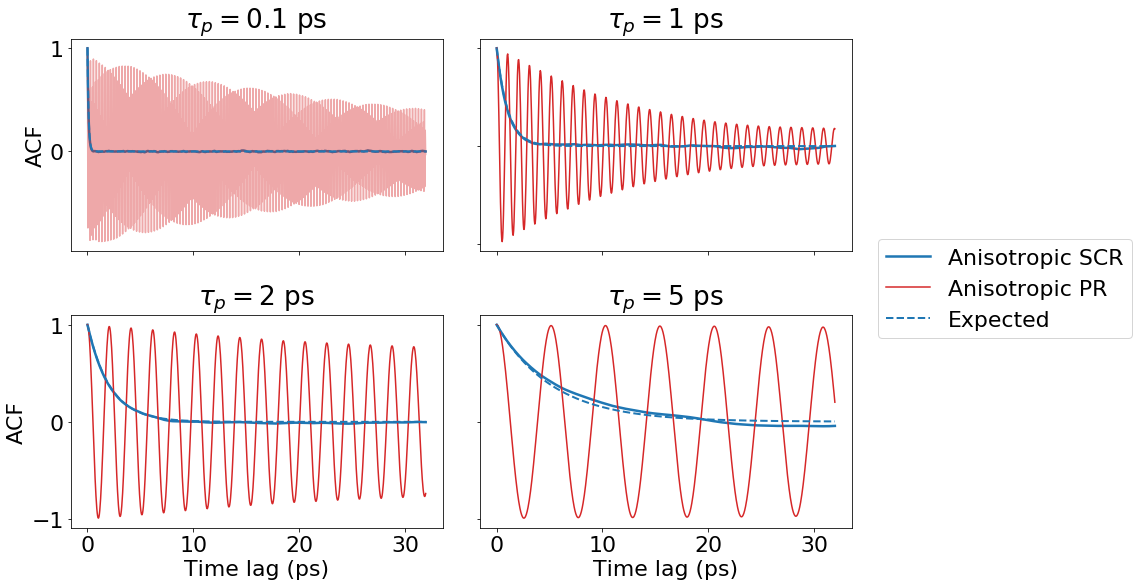

In [37]:
plt.rcParams.update({'font.size': 22})
labels = ['Anisotropic SCR','Anisotropic PR']
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:red', 'tab:purple','tab:brown','tab:cyan','tab:olive','tab:gray','tab:pink']
icolor = 0
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(14,9))   
fig.subplots_adjust(hspace=0.3,wspace=0.1)

dt = 0.002
stride_statistics = 20
times = np.arange(nlags)*dt*stride_statistics

ax1.plot(times,autocorr['A',tau_ps[0]],colors[0],linewidth=2.5,linestyle='-',label=labels[0])
ax1.plot(times,autocorr['APR',tau_ps[0]],colors[1],linestyle='-',label=labels[1],alpha=0.4)
ax1.plot(times,np.exp(-times/tau_ps_exp[0]),colors[0],linestyle='--',linewidth=2,label='Expected')
ax1.set(ylabel='ACF',title="$\\tau_p=$"+str(tau_ps[0])+" ps")
ax1.axes.xaxis.set_ticklabels([])

ax2.plot(times,autocorr['A',tau_ps[3]],colors[0],linewidth=2.5,linestyle='-',label=labels[0])
ax2.plot(times,autocorr['APR',tau_ps[3]],colors[1],linestyle='-',label=labels[1])
ax2.plot(times,np.exp(-times/tau_ps_exp[3]),colors[0],linestyle='--',linewidth=2)
ax2.set(title="$\\tau_p=$"+str(tau_ps[3])+" ps")
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])

ax3.plot(times,autocorr['A',tau_ps[4]],colors[0],linewidth=2.5,linestyle='-',label=labels[0])
ax3.plot(times,autocorr['APR',tau_ps[4]],colors[1],linestyle='-',label=labels[1])
ax3.plot(times,np.exp(-times/tau_ps_exp[4]),colors[0],linestyle='--',linewidth=2)
ax3.set(xlabel='Time lag (ps)',ylabel='ACF',title="$\\tau_p=$"+str(tau_ps[4])+" ps")

ax4.plot(times,autocorr['A',tau_ps[5]],colors[0],linewidth=2.5,linestyle='-',label=labels[0])
ax4.plot(times,autocorr['APR',tau_ps[5]],colors[1],linestyle='-',label=labels[1])
ax4.plot(times,np.exp(-times/tau_ps_exp[5]),colors[0],linestyle='--',linewidth=2,label='Expected')
ax4.set(xlabel='Time lag (ps)',title="$\\tau_p=$"+str(tau_ps[5])+" ps")
ax4.legend(bbox_to_anchor=(1.04,1.41), loc="upper left")
ax4.axes.yaxis.set_ticklabels([])

#plt.savefig("fig_acfs_argon.pdf", dpi=300, bbox_inches="tight") 
plt.show()

# Figures 5(a), 5(b)
### (LJ in GROMACS: standard errors on volume average and volume variance as functions of $\tau_p$)

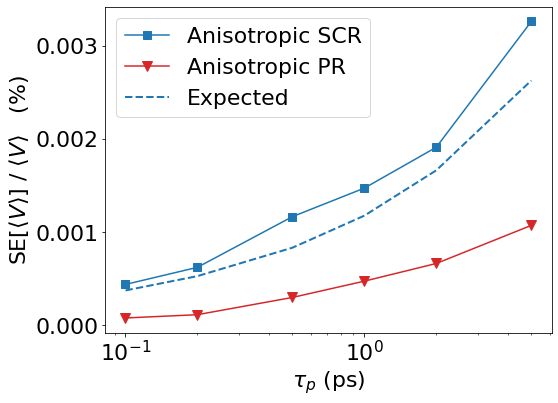

In [36]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(figsize=(8,6))
left, bottom, width, height = [0.25, 0.20, 0.5, 0.5]

labels = ['Anisotropic SCR','Anisotropic PR']
formats = ['s','v','d']
colors = ['tab:blue','tab:red','tab:olive']
markersizes = [8,10,10]

(ax1.plot(tau_ps[:-4],100*np.array(plt_errors['A','avg'])[:-4]/np.array(plt_values['A','avg'])[:-4],
          formats[0]+'-',color=colors[0],markersize=markersizes[0],label=labels[0]))
(ax1.plot(tau_ps[:-4],100*np.array(plt_errors['APR','avg'])[:-4]/np.array(plt_values['A','avg'])[:-4],
          formats[1]+'-',color=colors[1],markersize=markersizes[1],label=labels[1]))
(ax1.plot(tau_ps[:-4],100*np.sqrt(2/10000)*np.sqrt(plt_values['A','var'][3])*np.sqrt(np.array(tau_ps[:-4])) /
         np.array(plt_values['A','avg'])[:-4],'--',color='tab:blue',linewidth=2,label='Expected'))
ax1.set(xscale='log',xlabel='$\\tau_p$ (ps)',ylabel='SE[$\\langle V \\rangle$] / $\\langle V \\rangle$   (%)')
ax1.legend()
#plt.savefig("fig_se_avg_argon.pdf", dpi=300, bbox_inches="tight") 
plt.show()

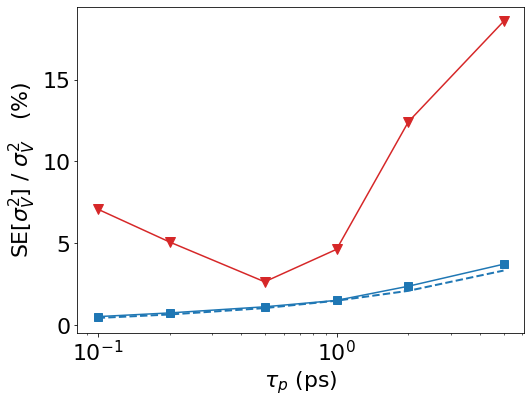

In [37]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(figsize=(8,6))
left, bottom, width, height = [0.25, 0.20, 0.5, 0.5]

labels = ['Anisotropic SCR','Anisotropic PR']
formats = ['s','v','d']
colors = ['tab:blue','tab:red','tab:olive']
markersizes = [8,10,10]

(ax1.plot(tau_ps[:-4],100*np.array(plt_errors['A','var'])[:-4]/np.array(plt_values['A','var'])[:-4],
          formats[0]+'-',color=colors[0],markersize=markersizes[0],label=labels[0]))
(ax1.plot(tau_ps[:-4],100*np.array(plt_errors['APR','var'])[:-4]/np.array(plt_values['APR','var'])[:-4],
          formats[1]+'-',color=colors[1],markersize=markersizes[1],label=labels[1]))
if not usePickle:
    std_variances = np.std((volume['A',1]-np.mean(volume['A',1]))**2)
else:
    std_variances = 0.001426 # result using trajectories
ax1.plot(tau_ps[:-4],100*np.sqrt(2/10000)*std_variances/np.array(plt_values['A','var'][:-4])*np.sqrt(np.array(tau_ps[:-4])/2),'--',color='tab:blue',linewidth=2,label='Expected')
ax1.set(xscale='log',xlabel='$\\tau_p$ (ps)',ylabel='SE[$\\sigma_V^2 $] / $\\sigma_V^2 $   (%)')
#plt.savefig("fig_se_var_argon.pdf", dpi=300, bbox_inches="tight") 
plt.show()

# Figures 6(a), 6(b)
### (Ice$_{Ih}$ in GROMACS and LAMMPS: average and variance of the volume as functions of $\tau_p$)

In [38]:
tau_ps = [0.1,0.2,0.5,1,2] # tau_p values employed

Loading data:

In [39]:
if not usePickle:
    volume = {}
    print("SCR_GMX\t\tPR_GMX\t\tSCR_LMP\t\tMTTK_LMP")

    times = np.loadtxt("Ice/volume_iso_tp_0.1.xvg",comments=['#','@'])[:,0]

    for tau_p in tau_ps:
        volume['ACR_GMX',tau_p] = np.loadtxt("Ice/volume_aniso_tp_" +str(tau_p)+".xvg",comments=['#','@'])[:,1]
        volume['APR_GMX',tau_p] = np.loadtxt("Ice/volume_aniso_PR_tp_" +str(tau_p)+".xvg",comments=['#','@'])[:,1]

        log_lammps_A = lammps_logfile.File("Ice/lammps_tri_taup_"+str(tau_p)+".log")
        log_lammps_AMTTK = lammps_logfile.File("Ice/lammps_MTTK_taup_"+str(tau_p)+".log")
        volume['ACR_LMP',tau_p] = log_lammps_A.get("Volume") / 1000
        volume['AMTTK_LMP',tau_p] = log_lammps_AMTTK.get("Volume") / 1000

        (print(str(len(volume['ACR_GMX',tau_p]))+"\t\t"+str(len(volume['APR_GMX',tau_p]))+"\t\t"+str(len(volume['ACR_LMP',tau_p]))+
              "\t\t"+str(len(volume['AMTTK_LMP',tau_p]))))

Block-bootstrap analysis:

In [40]:
if not usePickle:
    nbs = np.logspace(math.log(3,10), math.log(40001,10), num=50,dtype=int)[1:]
    print("\nLength of blocks n_b employed in block analysis:\n" + str(nbs))

In [41]:
if not usePickle:
    start_time = time.time()

    start=40000 
    plt_values = {}
    errors = {}
    plt_errors = {}
    keys = ['avg','var']
    barostats=['ACR_GMX','APR_GMX','ACR_LMP','AMTTK_LMP']
    for baro in barostats:
        for key in keys:
            for tp in tau_ps: 
                errors[baro,key,tp] = []
            plt_values[baro,key] = []
            plt_errors[baro,key] = []
    for baro in barostats:
        for tp in tau_ps:
            for iblock in range(len(nbs)): 
                avg, err_avg, var, err_var = block_bootstrap(np.array(volume[baro,tp][start:]),nbs[iblock])
                errors[baro,'avg',tp].append(err_avg)
                errors[baro,'var',tp].append(err_var)
            plt_values[baro,'avg'].append(avg) # NB independent on number of blocks
            plt_values[baro,'var'].append(var)           
    for tp in tau_ps:
        for case in keys:
            for baro in barostats:
                plt_errors[baro,case].append(max(errors[baro,case,tp]))

    end_time = time.time()
    print("Execution time: "+ str(end_time - start_time))
    
    #pickle.dump([plt_values,plt_errors],open("plt_Ice.p","wb"))

In [42]:
if usePickle:
    plt_values,plt_errors=pickle.load(open("plt_Ice.p","rb"))

#### Figure 6(a)

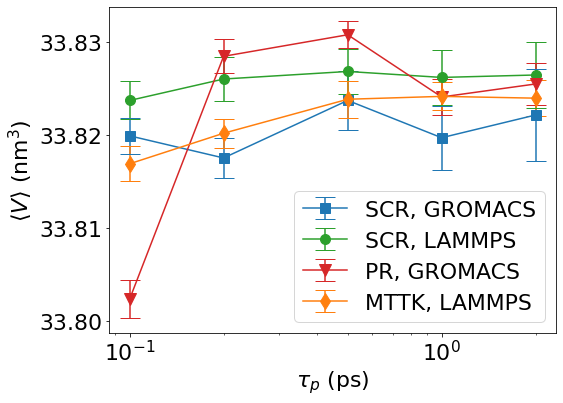

In [43]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(figsize=(8,6))
left, bottom, width, height = [0.20, 0.45, 0.4, 0.4]


labels = ['SCR, GROMACS', 'SCR, LAMMPS', 'PR, GROMACS','MTTK, LAMMPS']
formats = ['s','o','v','d']
colors = ['tab:blue','tab:green','tab:red','tab:orange']
markersizes = [10,10,12,12]

index = 0
for baro in ['ACR_GMX','ACR_LMP','APR_GMX','AMTTK_LMP']:
    (ax1.errorbar(tau_ps,plt_values[baro,'avg'],plt_errors[baro,'avg'],fmt=formats[index]+'-',
                 color=colors[index],capsize=10,markersize=markersizes[index],label=labels[index]))
    index+=1
ax1.set(xscale='log',xlabel='$\\tau_p$ (ps)',ylabel='$\\langle V \\rangle$ (nm$^3$)')
ax1.legend()
#plt.savefig("fig_avgs_ice.pdf", dpi=300, bbox_inches="tight") 
plt.show()

#### Figure 6(b)

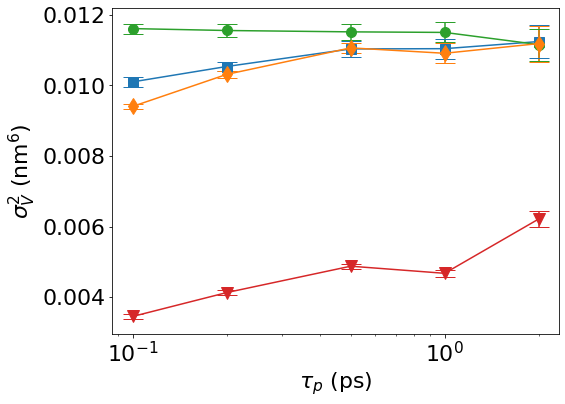

In [44]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(figsize=(8,6))
left, bottom, width, height = [0.2, 0.2, 0.35, 0.3]

labels = ['SCR, GROMACS', 'SCR, LAMMPS', 'PR, GROMACS','MTTK, LAMMPS']
formats = ['s','o','v','d']
colors = ['tab:blue','tab:green','tab:red','tab:orange']
markersizes = [10,10,12,12]
shifts = np.array([0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10])

index = 0
for baro in ['ACR_GMX','ACR_LMP','APR_GMX','AMTTK_LMP']:
    (ax1.errorbar(tau_ps,plt_values[baro,'var'],plt_errors[baro,'var'],fmt=formats[index]+'-',
                 color=colors[index],capsize=10,markersize=markersizes[index],label=labels[index]))
    index+=1
ax1.set(xscale='log',xlabel='$\\tau_p$ (ps)',ylabel='$\\sigma_V^2$ (nm$^6$)')#,ylim=[-0.002,0.039])
#plt.savefig("fig_vars_ice.pdf", dpi=300, bbox_inches="tight") 
plt.show()

# Figure 7
### (Ice$_{Ih}$ in GROMACS and LAMMPS: volume autocorrelation functions for different $\tau_p$ values)
Computing the autocorrelation functions:

In [62]:
nlags = 300
start = 40000
autocorr={}
if not usePickle:
    for tp in tau_ps:
        autocorr['ACR_GMX',tp]=autocorr2(volume['ACR_GMX',tp][start:])[:nlags]
        autocorr['APR_GMX',tp]=autocorr2(volume['APR_GMX',tp][start:])[:nlags]
        autocorr['ACR_LMP',tp]=autocorr2(volume['ACR_LMP',tp][start:])[:nlags]
        autocorr['AMTTK_LMP',tp]=autocorr2(volume['AMTTK_LMP',tp][start:])[:nlags]
    #pickle.dump(autocorr,open("autocorr_Ice.p","wb"))
else:
    autocorr=pickle.load(open("autocorr_Ice.p","rb"))    

Correcting a posteriori the values of $\tau_p$, by computing the real isothermal compressibility $\beta_T$:

In [63]:
tau_ps = [0.1,0.2,0.5,1,2]
betaT_input = 9.4863e-6
kbT = kB*270
conversion_factor = 1e-22 # from nm^3/joules to bar^(-1)
betaT_exp = plt_values['ACR_LMP','var'][3]/(kbT*plt_values['ACR_LMP','avg'][3])*conversion_factor
tau_ps_exp = betaT_exp / betaT_input * np.array(tau_ps)

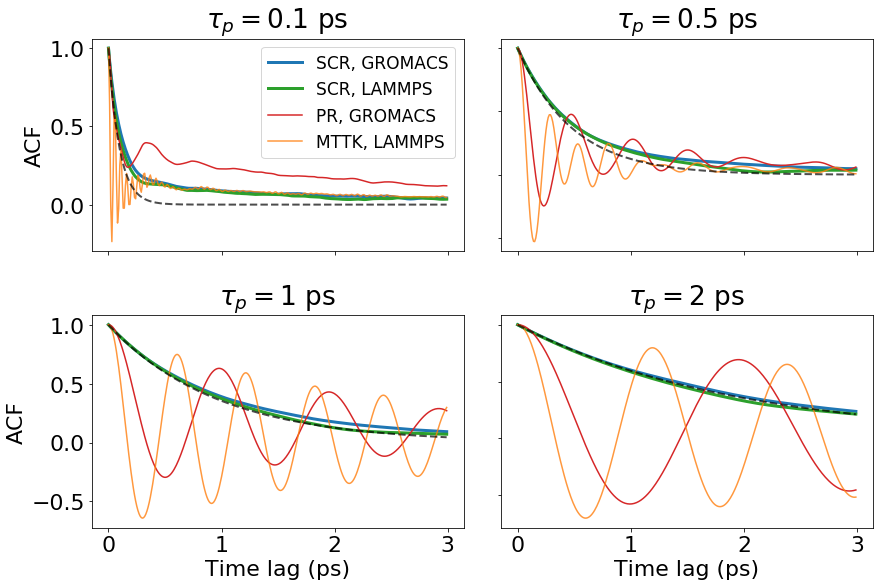

In [64]:
plt.rcParams.update({'font.size': 22})
labels = ['SCR, GROMACS','SCR, LAMMPS','PR, GROMACS','MTTK, LAMMPS']
formats = ['s','o','v','d']
colors = ['tab:blue','tab:green','tab:red','tab:orange']
markersizes = [10,10,12,12]
icolor = 0
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(14,9))   
fig.subplots_adjust(hspace=0.3,wspace=0.1)

dt = 0.001
stride_statistics = 10
times = np.arange(nlags)*dt*stride_statistics

ax1.plot(times,autocorr['ACR_GMX',tau_ps[0]],colors[0],linewidth=3,linestyle='-',label=labels[0])
ax1.plot(times,autocorr['ACR_LMP',tau_ps[0]],colors[1],linewidth=3,linestyle='-',label=labels[1])
ax1.plot(times,autocorr['APR_GMX',tau_ps[0]],colors[2],linestyle='-',label=labels[2],alpha=1)
ax1.plot(times,autocorr['AMTTK_LMP',tau_ps[0]],colors[3],linestyle='-',label=labels[3],alpha=0.8)
ax1.plot(times,np.exp(-times/tau_ps_exp[0]),linestyle='--',linewidth=2,color='k',alpha=0.7)
ax1.set(ylabel='ACF',title="$\\tau_p=$"+str(tau_ps[0])+" ps")
ax1.axes.xaxis.set_ticklabels([])
ax1.legend(fontsize=17)

ax2.plot(times,autocorr['ACR_GMX',tau_ps[2]],colors[0],linewidth=3,linestyle='-',label=labels[0])
ax2.plot(times,autocorr['ACR_LMP',tau_ps[2]],colors[1],linewidth=3,linestyle='-',label=labels[1])
ax2.plot(times,autocorr['APR_GMX',tau_ps[2]],colors[2],linestyle='-',label=labels[2],alpha=1)
ax2.plot(times,autocorr['AMTTK_LMP',tau_ps[2]],colors[3],linestyle='-',label=labels[3],alpha=0.8)
ax2.plot(times,np.exp(-times/tau_ps_exp[2]),linestyle='--',linewidth=2,color='k',alpha=0.7)
ax2.set(title="$\\tau_p=$"+str(tau_ps[2])+" ps")
ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])

ax3.plot(times,autocorr['ACR_GMX',tau_ps[3]],colors[0],linewidth=3,linestyle='-',label=labels[0])
ax3.plot(times,autocorr['ACR_LMP',tau_ps[3]],colors[1],linewidth=3,linestyle='-',label=labels[1])
ax3.plot(times,autocorr['APR_GMX',tau_ps[3]],colors[2],linestyle='-',label=labels[2],alpha=1)
ax3.plot(times,autocorr['AMTTK_LMP',tau_ps[3]],colors[3],linestyle='-',label=labels[3],alpha=0.8)
ax3.plot(times,np.exp(-times/tau_ps_exp[3]),linestyle='--',linewidth=2,color='k',alpha=0.7)
ax3.set(ylabel='ACF',xlabel='Time lag (ps)',title="$\\tau_p=$"+str(tau_ps[3])+" ps")

ax4.plot(times,autocorr['ACR_GMX',tau_ps[4]],colors[0],linewidth=3,linestyle='-',label=labels[0])
ax4.plot(times,autocorr['ACR_LMP',tau_ps[4]],colors[1],linewidth=3,linestyle='-',label=labels[1])
ax4.plot(times,autocorr['APR_GMX',tau_ps[4]],colors[2],linestyle='-',label=labels[2],alpha=1)
ax4.plot(times,autocorr['AMTTK_LMP',tau_ps[4]],colors[3],linestyle='-',label=labels[3],alpha=0.8)
ax4.plot(times,np.exp(-times/tau_ps_exp[4]),linestyle='--',linewidth=2,color='k',alpha=0.7)
ax4.set(xlabel='Time lag (ps)',title="$\\tau_p=$"+str(tau_ps[4])+" ps")
ax4.axes.yaxis.set_ticklabels([])

#plt.savefig("fig_acfs_ice.pdf", dpi=300, bbox_inches="tight") 
plt.show()

# Figures 8(a), 8(b)
### (Ice$_{Ih}$ in GROMACS and LAMMPS: average and variance of mutual scalar products of cell vectors)

In [45]:
tau_ps = [0.1,0.2,0.5,1,2] # tau_p values employed

Loading data:

In [46]:
if not usePickle:
    box = {}

    # read GROMACS files
    components = ['XX','YY','ZZ','YX','ZX','ZY']
    for tp in tau_ps:
        for comp in components:
            box['ACR_GMX',comp,tp] = np.loadtxt("Ice/box_"+comp+"_aniso_tp_"+str(tp)+".xvg",comments=['#','@'])
            box['APR_GMX',comp,tp] = np.loadtxt("Ice/box_"+comp+"_aniso_PR_tp_"+str(tp)+".xvg",comments=['#','@'])

    # read LAMMPS files
    components_lammps = ["Cella","Cellb","Cellc","CellAlpha","CellBeta","CellGamma"]    
    for tp in tau_ps:
        log_lammps_A = lammps_logfile.File("Ice/lammps_tri_taup_"+str(tp)+".log")
        log_lammps_AMTTK = lammps_logfile.File("Ice/lammps_MTTK_taup_"+str(tp)+".log")
        for comp_lammps in components_lammps:
            box["ACR_LMP",comp_lammps,tp] = log_lammps_A.get(comp_lammps)
            box["AMTTK_LMP",comp_lammps,tp] = log_lammps_AMTTK.get(comp_lammps)
        box["ACR_LMP","Cella",tp] /= 10 #convert from angstrom to nm
        box["ACR_LMP","Cellb",tp] /= 10 
        box["ACR_LMP","Cellc",tp] /= 10
        box["AMTTK_LMP","Cella",tp] /= 10
        box["AMTTK_LMP","Cellb",tp] /= 10 
        box["AMTTK_LMP","Cellc",tp] /= 10

Computing scalar products and squared moduli:

In [47]:
if not usePickle: 
    mod_scalar = {}
    mod2_strings = ['1','2','3']
    scalars_strings = ['12','13','23']

    for case in ['ACR_GMX','APR_GMX']:
        for tp in tau_ps:
            mod_scalar[case,'1',tp] = box[case,'XX',tp][:,1]**2
            mod_scalar[case,'2',tp] = box[case,'YX',tp][:,1]**2 + box[case,'YY',tp][:,1]**2
            mod_scalar[case,'3',tp] = box[case,'ZX',tp][:,1]**2 + box[case,'ZY',tp][:,1]**2 + box[case,'ZZ',tp][:,1]**2
            mod_scalar[case,'12',tp] = box[case,'XX',tp][:,1]*box[case,'YX',tp][:,1]
            mod_scalar[case,'13',tp] = box[case,'XX',tp][:,1]*box[case,'ZX',tp][:,1]
            mod_scalar[case,'23',tp] = box[case,'YX',tp][:,1]*box[case,'ZX',tp][:,1] + box[case,'YY',tp][:,1]*box[case,'ZY',tp][:,1] 

    for case in ['ACR_LMP','AMTTK_LMP']:
        for tp in tau_ps:
            mod_scalar[case,'1',tp] = box[case,'Cella',tp]**2
            mod_scalar[case,'2',tp] = box[case,'Cellb',tp]**2 
            mod_scalar[case,'3',tp] = box[case,'Cellc',tp]**2
            mod_scalar[case,'12',tp] = box[case,'Cella',tp]*box[case,'Cellb',tp]*np.cos(np.deg2rad(box[case,'CellAlpha',tp]))
            mod_scalar[case,'13',tp] = box[case,'Cella',tp]*box[case,'Cellc',tp]*np.cos(np.deg2rad(box[case,'CellBeta',tp]))
            mod_scalar[case,'23',tp] = box[case,'Cellb',tp]*box[case,'Cellc',tp]*np.cos(np.deg2rad(box[case,'CellGamma',tp]))

Block-bootstrap analysis:

In [49]:
if not usePickle: 
    nbs = np.logspace(math.log(3,10), math.log(40001,10), num=50,dtype=int)[1:]
    print("\nLength of blocks n_b employed in block analysis:\n" + str(nbs))

In [50]:
if not usePickle:
    start_time = time.time()

    start=40000 
    plt_values = {}
    errors = {}
    plt_errors = {}
    keys = ['avg','var']
    strings = ['1','2','3','12','13','23']
    barostats=['ACR_GMX','APR_GMX','ACR_LMP','AMTTK_LMP']
    for string in strings:
        for key in keys:
            for baro in barostats:
                for tp in tau_ps: 
                    errors[baro,string,key,tp] = []
                plt_values[baro,string,key] = []
                plt_errors[baro,string,key] = []
    for string in strings:
        for baro in barostats:
            for tp in tau_ps:
                for iblock in range(len(nbs)): 
                    avg, err_avg, var, err_var = block_bootstrap(np.array(mod_scalar[baro,string,tp][start:]),nbs[iblock])
                    errors[baro,string,'avg',tp].append(err_avg)
                    errors[baro,string,'var',tp].append(err_var)
                plt_values[baro,string,'avg'].append(avg) # NB independent on number of blocks
                plt_values[baro,string,'var'].append(var) 
    for string in strings:
        for baro in barostats:
            for key in keys:
                for tp in tau_ps:
                    plt_errors[baro,string,key].append(max(errors[baro,string,key,tp]))

    end_time = time.time()
    print("Execution time: "+ str(end_time - start_time))
    
    #pickle.dump([plt_values,plt_errors],open("plt_box_Ice.p","wb"))

In [51]:
if usePickle:
    plt_values,plt_errors=pickle.load(open("plt_box_Ice.p","rb"))

#### Figure 8(a)

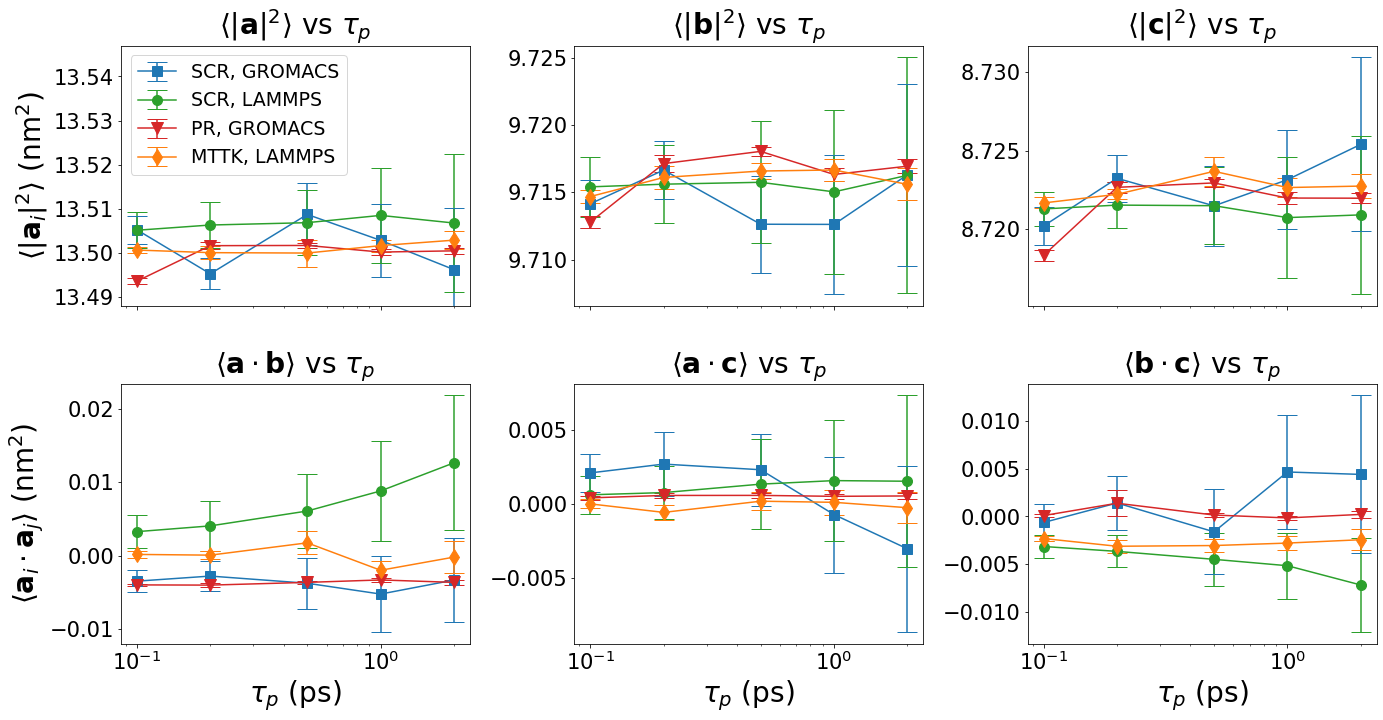

In [52]:
plt.rcParams.update({'font.size': 21})
fontsize=28

labels = ['SCR, GROMACS', 'SCR, LAMMPS', 'PR, GROMACS','MTTK, LAMMPS']
formats = ['s','o','v','d']
markersizes = [10,10,12,12,12]
colors = ['tab:blue','tab:green','tab:red','tab:orange']

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(22.5,11))   
titles = ['$\\langle |\\mathbf{a}|^2 \\rangle$ vs $\\tau_p$','$ \\langle |\\mathbf{b}|^2 \\rangle$ vs $\\tau_p$','$\\langle |\\mathbf{c}|^2 \\rangle$ vs $\\tau_p$','$\\langle \\mathbf{a}\\cdot\\mathbf{b}\\rangle$ vs $\\tau_p$','$\\langle \\mathbf{a}\\cdot\\mathbf{c}\\rangle$ vs $\\tau_p$','$\\langle \\mathbf{b}\\cdot\\mathbf{c}\\rangle$ vs $\\tau_p$']
fig.subplots_adjust(hspace=0.3,wspace=0.3)

index = 0
for case in ['ACR_GMX','ACR_LMP','APR_GMX','AMTTK_LMP']:
    ax1.errorbar(tau_ps,plt_values[case,'1','avg'],plt_errors[case,'1','avg'],fmt=formats[index]+'-',capsize=10,markersize=markersizes[index],label=labels[index],color=colors[index])
    index+=1
ax1.set(xscale='log',ylabel='$\\langle |\\mathbf{a}_i|^2 \\rangle $ (nm$^2$)',title=titles[0],ylim=[13.488,13.547])
ax1.axes.xaxis.set_ticklabels([])
ax1.legend(fontsize=19)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(fontsize)

index = 0
for case in ['ACR_GMX','ACR_LMP','APR_GMX','AMTTK_LMP']:
    ax2.errorbar(tau_ps,plt_values[case,'2','avg'],plt_errors[case,'2','avg'],fmt=formats[index]+'-',capsize=10,markersize=markersizes[index],label=labels[index],color=colors[index])
    index+=1
ax2.set(xscale='log',title=titles[1])
ax2.axes.xaxis.set_ticklabels([])
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label]):
    item.set_fontsize(fontsize)

index = 0
for case in ['ACR_GMX','ACR_LMP','APR_GMX','AMTTK_LMP']:
    ax3.errorbar(tau_ps,plt_values[case,'3','avg'],plt_errors[case,'3','avg'],fmt=formats[index]+'-',capsize=10,markersize=markersizes[index],label=labels[index],color=colors[index])
    index+=1
ax3.set(xscale='log',title=titles[2])
ax3.axes.xaxis.set_ticklabels([])
for item in ([ax3.title, ax3.xaxis.label, ax3.yaxis.label]):
    item.set_fontsize(fontsize)

index = 0
for case in ['ACR_GMX','ACR_LMP','APR_GMX','AMTTK_LMP']:
    ax4.errorbar(tau_ps,plt_values[case,'12','avg'],plt_errors[case,'12','avg'],fmt=formats[index]+'-',capsize=10,markersize=markersizes[index],label=labels[index],color=colors[index])
    index+=1
ax4.set(xscale='log',xlabel='$\\tau_p$ (ps)',ylabel='$\\langle \\mathbf{a}_i \\cdot\\mathbf{a}_j \\rangle $ (nm$^2$)',title=titles[3])
for item in ([ax4.title, ax4.xaxis.label, ax4.yaxis.label]):
    item.set_fontsize(fontsize)

index = 0
for case in ['ACR_GMX','ACR_LMP','APR_GMX','AMTTK_LMP']:
    ax5.errorbar(tau_ps,plt_values[case,'13','avg'],plt_errors[case,'13','avg'],fmt=formats[index]+'-',capsize=10,markersize=markersizes[index],label=labels[index],color=colors[index])
    index+=1
ax5.set(xscale='log',xlabel='$\\tau_p$ (ps)',title=titles[4])
for item in ([ax5.title, ax5.xaxis.label, ax5.yaxis.label]):
    item.set_fontsize(fontsize)
#ax1.legend(fontsize=17)

index = 0
for case in ['ACR_GMX','ACR_LMP','APR_GMX','AMTTK_LMP']:
    ax6.errorbar(tau_ps,plt_values[case,'23','avg'],plt_errors[case,'23','avg'],fmt=formats[index]+'-',capsize=10,markersize=markersizes[index],label=labels[index],color=colors[index])
    index+=1
ax6.set(xscale='log',xlabel='$\\tau_p$ (ps)',title=titles[5])
for item in ([ax6.title, ax6.xaxis.label, ax6.yaxis.label]):
    item.set_fontsize(fontsize)

#plt.savefig("fig_avgs_comp_ice.pdf", dpi=300, bbox_inches="tight") 
plt.show()

#### Figure 8(b)

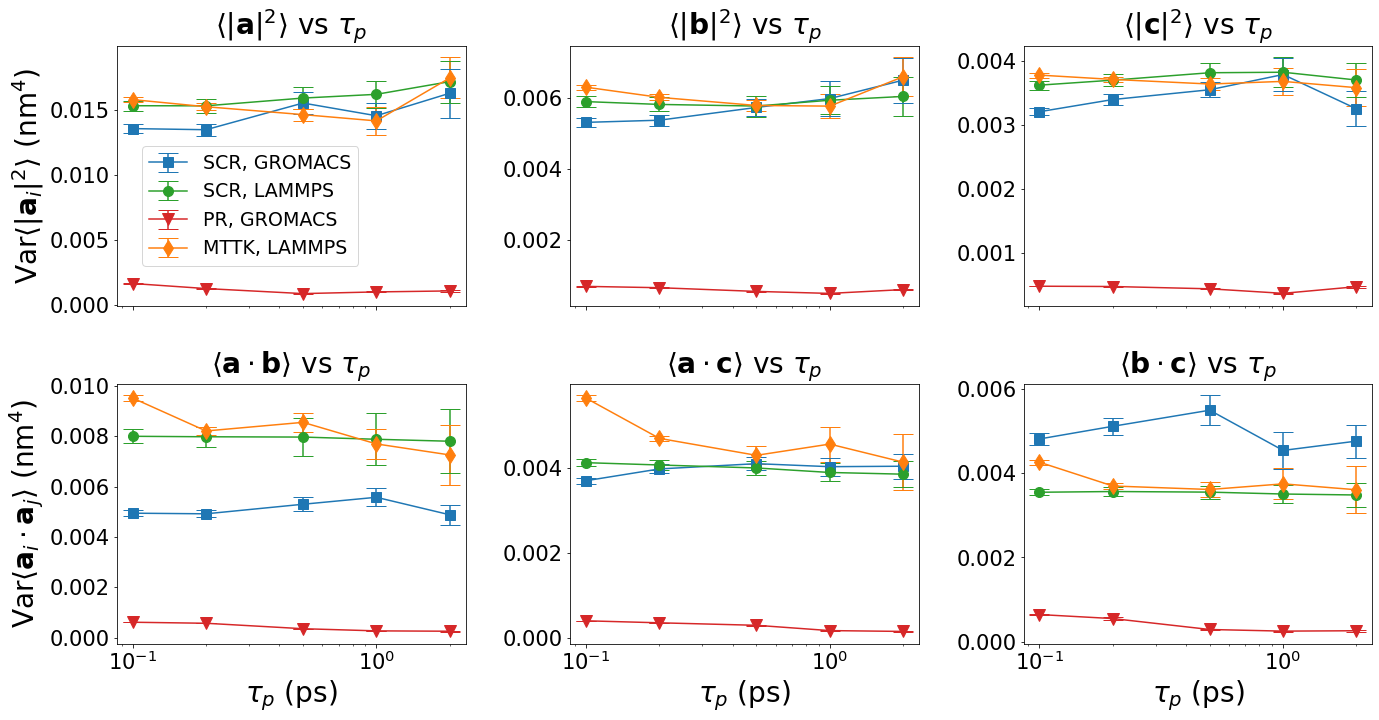

In [53]:
plt.rcParams.update({'font.size': 21})

labels = ['SCR, GROMACS', 'SCR, LAMMPS', 'PR, GROMACS','MTTK, LAMMPS']
formats = ['s','o','v','d']
markersizes = [10,10,12,12,12]
colors = ['tab:blue','tab:green','tab:red','tab:orange']
fontsize=28

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(22.5,11))   
titles = ['$\\langle |\\mathbf{a}|^2 \\rangle$ vs $\\tau_p$','$ \\langle |\\mathbf{b}|^2 \\rangle$ vs $\\tau_p$','$\\langle |\\mathbf{c}|^2 \\rangle$ vs $\\tau_p$','$\\langle \\mathbf{a}\\cdot\\mathbf{b}\\rangle$ vs $\\tau_p$','$\\langle \\mathbf{a}\\cdot\\mathbf{c}\\rangle$ vs $\\tau_p$','$\\langle \\mathbf{b}\\cdot\\mathbf{c}\\rangle$ vs $\\tau_p$']
fig.subplots_adjust(hspace=0.3,wspace=0.3)

index = 0
for case in ['ACR_GMX','ACR_LMP','APR_GMX','AMTTK_LMP']:
    ax1.errorbar(tau_ps,plt_values[case,'1','var'],plt_errors[case,'1','var'],fmt=formats[index]+'-',capsize=10,markersize=markersizes[index],label=labels[index],color=colors[index])
    index+=1
ax1.set(xscale='log',ylabel='Var$\\langle |\\mathbf{a}_i|^2 \\rangle $ (nm$^4$)',title=titles[0])#,ylim=[13.488,13.547])
ax1.axes.xaxis.set_ticklabels([])
ax1.legend(bbox_to_anchor=(0.72, 0.65),fontsize=19)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(fontsize)

index = 0
for case in ['ACR_GMX','ACR_LMP','APR_GMX','AMTTK_LMP']:
    ax2.errorbar(tau_ps,plt_values[case,'2','var'],plt_errors[case,'2','var'],fmt=formats[index]+'-',capsize=10,markersize=markersizes[index],label=labels[index],color=colors[index])
    index+=1
ax2.set(xscale='log',title=titles[1])
ax2.axes.xaxis.set_ticklabels([])
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label]):
    item.set_fontsize(fontsize)

index = 0
for case in ['ACR_GMX','ACR_LMP','APR_GMX','AMTTK_LMP']:
    ax3.errorbar(tau_ps,plt_values[case,'3','var'],plt_errors[case,'3','var'],fmt=formats[index]+'-',capsize=10,markersize=markersizes[index],label=labels[index],color=colors[index])
    index+=1
ax3.set(xscale='log',title=titles[2])
ax3.axes.xaxis.set_ticklabels([])
for item in ([ax3.title, ax3.xaxis.label, ax3.yaxis.label]):
    item.set_fontsize(fontsize)

index = 0
for case in ['ACR_GMX','ACR_LMP','APR_GMX','AMTTK_LMP']:
    ax4.errorbar(tau_ps,plt_values[case,'12','var'],plt_errors[case,'12','var'],fmt=formats[index]+'-',capsize=10,markersize=markersizes[index],label=labels[index],color=colors[index])
    index+=1
ax4.set(xscale='log',xlabel='$\\tau_p$ (ps)',ylabel='Var$\\langle \\mathbf{a}_i \\cdot\\mathbf{a}_j \\rangle $ (nm$^4$)',title=titles[3])
for item in ([ax4.title, ax4.xaxis.label, ax4.yaxis.label]):
    item.set_fontsize(fontsize)

index = 0
for case in ['ACR_GMX','ACR_LMP','APR_GMX','AMTTK_LMP']:
    ax5.errorbar(tau_ps,plt_values[case,'13','var'],plt_errors[case,'13','var'],fmt=formats[index]+'-',capsize=10,markersize=markersizes[index],label=labels[index],color=colors[index])
    index+=1
ax5.set(xscale='log',xlabel='$\\tau_p$ (ps)',title=titles[4])
for item in ([ax5.title, ax5.xaxis.label, ax5.yaxis.label]):
    item.set_fontsize(fontsize)

index = 0
for case in ['ACR_GMX','ACR_LMP','APR_GMX','AMTTK_LMP']:
    ax6.errorbar(tau_ps,plt_values[case,'23','var'],plt_errors[case,'23','var'],fmt=formats[index]+'-',capsize=10,markersize=markersizes[index],label=labels[index],color=colors[index])
    index+=1
ax6.set(xscale='log',xlabel='$\\tau_p$ (ps)',title=titles[5])
for item in ([ax6.title, ax6.xaxis.label, ax6.yaxis.label]):
    item.set_fontsize(fontsize)

#plt.savefig("fig_vars_comp_ice.pdf", dpi=300, bbox_inches="tight") 

plt.show()

# Figures 9(a), 9(b)
### (Gypsum in LAMMPS: autocorrelation functions of volume and volume variance)

Loading data:

In [54]:
if not usePickle:
    log_lammps_tri = lammps_logfile.File("Gypsum/lammps_tri_taup_0.1.log")
    log_lammps_tri_MTTK = lammps_logfile.File("Gypsum/lammps_tri_MTTK_taup_0.1.log")

    time = {}
    volume = {}
    time['ACR_LMP'] = log_lammps_tri.get("Time")
    time['AMTTK_LMP'] = log_lammps_tri_MTTK.get("Time")
    volume['ACR_LMP'] = log_lammps_tri.get("Volume")/ 1000
    volume['AMTTK_LMP'] = log_lammps_tri_MTTK.get("Volume") / 1000

    print(len(time['ACR_LMP']),len(time['AMTTK_LMP']))

Computing the autocorrelation functions:

In [55]:
start = 40000
autocorr = {}
autocorrvar = {}
if not usePickle:
    autocorr['ACR_LMP'] = autocorr2(volume['ACR_LMP'][start:])
    autocorr['AMTTK_LMP'] = autocorr2(volume['AMTTK_LMP'][start:])
    autocorrvar['ACR_LMP'] = autocorr2((volume['ACR_LMP'][start:]-np.mean(volume['ACR_LMP'][start:]))**2)
    autocorrvar['AMTTK_LMP'] = autocorr2((volume['AMTTK_LMP'][start:]-np.mean(volume['AMTTK_LMP'][start:]))**2)
    
    avg_volume = np.mean(volume['ACR_LMP'][start:])
    var_volume = np.var(volume['ACR_LMP'][start:])
    
    #pickle.dump([avg_volume,var_volume,time,autocorr,autocorrvar],open("autocorr_Gypsum.p","wb"))
else:
    avg_volume,var_volume,time,autocorr,autocorrvar = pickle.load(open("autocorr_Gypsum.p","rb"))    

Correcting a posteriori the value of $\tau_p$, by computing the real bulk modulus $\beta_T^{-1}$:

In [56]:
tau_p = 0.1
bulkmod_input = 435415 # units: bar
kbT = kB*270
conversion_factor = 1e-22 # from nm^3/joules to bar^(-1)
bulkmod_exp = 1/(var_volume/(kbT*avg_volume)*conversion_factor)
tau_p_exp = bulkmod_input / bulkmod_exp * tau_p

#### Figure 9(a)

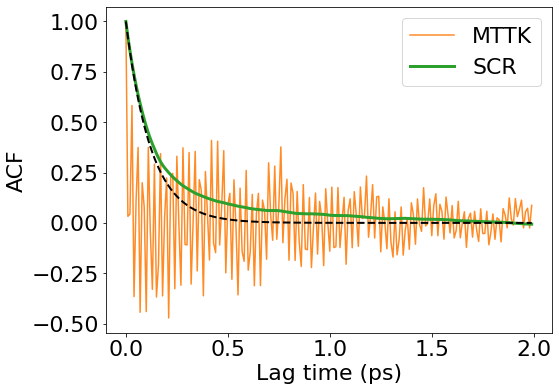

In [57]:
nlags = 200
plt.rcParams.update({'font.size': 22})
labels = ['SCR, $\\tau_p = 0.1$ ps','MTTK, $\\tau_p = 0.1$ ps']
colors = ['tab:green', 'tab:orange']

plt.figure(figsize=(8,6))   
times = time['ACR_LMP'][:nlags]
plt.plot(times[:nlags],autocorr['AMTTK_LMP'][:nlags],linestyle='-',label='MTTK',color=colors[1],alpha=0.9)
plt.plot(times[:nlags],autocorr['ACR_LMP'][:nlags],linewidth=3,linestyle='-',label='SCR',color=colors[0])
plt.plot(times[:nlags],np.exp(-times[:nlags]/tau_p_exp),color='k',linewidth=2,linestyle='--')
plt.xlabel("Lag time (ps)")
plt.ylabel('ACF')
plt.legend()

#plt.savefig("fig_acf_avg_gypsum.pdf", dpi=300, bbox_inches="tight") 
plt.show()

#### Figure 9(b)

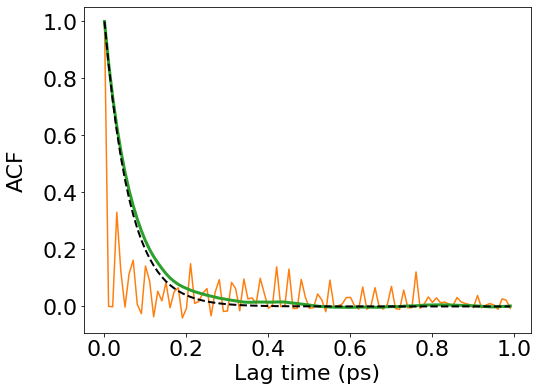

In [58]:
nlags = 100
plt.rcParams.update({'font.size': 22})
labels = ['SCR, $\\tau_p = 0.1$ ps','MTTK, $\\tau_p = 0.1$ ps']
colors = ['tab:green', 'tab:orange']
icolor = 0

plt.figure(figsize=(8,6))   
times = time['ACR_LMP'][:nlags]
plt.plot(times[:nlags],autocorrvar['AMTTK_LMP'][:nlags],linestyle='-',label='MTTK',color=colors[1])
plt.plot(times[:nlags],autocorrvar['ACR_LMP'][:nlags],linewidth=3,linestyle='-',label='SCR',color=colors[0])
plt.plot(times[:nlags],np.exp(-times[:nlags]/(0.5*tau_p_exp)),color='k',linewidth=2,linestyle='--')
icolor=icolor+1
plt.xlabel("Lag time (ps)")
plt.ylabel('ACF',labelpad=15)

#plt.savefig("fig_acf_var_gypsum.pdf", dpi=300, bbox_inches="tight") 
plt.show()

# Figure 10
### (Gold in LAMMPS: trajectory of the modulus of the b cell vector)

Loading data:

In [59]:
box_comp = {}
if not usePickle:
    log_lammps_tri_cr = lammps_logfile.File("Gold/lammps_crescale_taup_0.1.log")
    log_lammps_tri_mttk = lammps_logfile.File("Gold/lammps_MTTK_taup_1.log")
    
    times = log_lammps_tri_cr.get("Time")[:35200]
    for string in strings:
        box_comp['cr'] = log_lammps_tri_cr.get("Cellb")[:35200] / 1000
        box_comp['mttk'] = log_lammps_tri_mttk.get("Cellb")[:35200] / 1000
    
    #pickle.dump([times,box_comp],open("plt_Gold.p","wb"))
else:
    times, box_comp = pickle.load(open("plt_Gold.p","rb"))

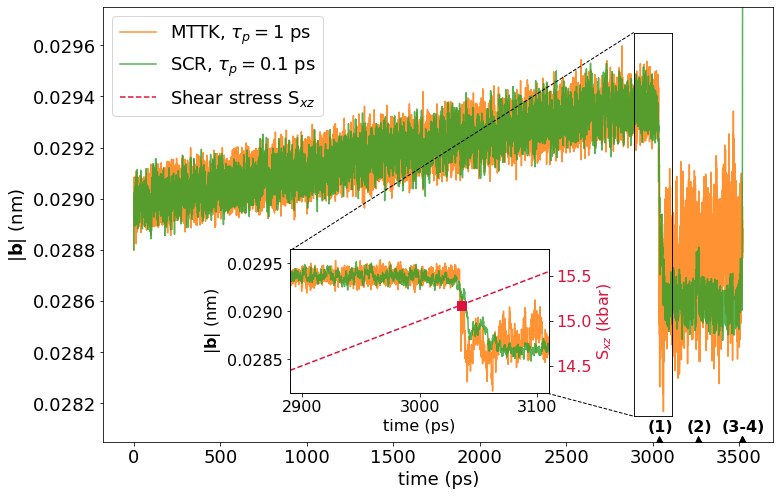

In [60]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(12,8))
left, bottom, width, height = [0.341, 0.21, 0.3, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])

x1,x2,y1,y2=2890,3110,0.02815,0.02965

ax1.plot(times ,box_comp['mttk'],label='MTTK, $\\tau_p = 1$ ps',color='tab:orange',alpha=0.85)
ax1.plot(times ,box_comp['cr'],label='SCR, $\\tau_p = 0.1$ ps',color='tab:green',alpha=0.8)
ax1.plot(np.linspace(x1,x2,2),y1*np.ones(2),'k',linewidth=0.9)
ax1.plot(np.linspace(x1,x2,2),y2*np.ones(2),'k',linewidth=0.9)
ax1.plot(x1*np.ones(2),np.linspace(y1,y2,2),'k',linewidth=0.9)
ax1.plot(x2*np.ones(2),np.linspace(y1,y2,2),'k',linewidth=0.9)
ax1.plot(np.linspace(910,x1,2),np.linspace(0.0288,y2,2),'k--',linewidth=1.)
ax1.plot(np.linspace(2390,x1,2),np.linspace(0.02824,y1,2),'k--',linewidth=1.)
color='#DC143C'
handles, labels = ax1.get_legend_handles_labels()
line = Line2D([0], [0], linestyle='--',label='Shear stress S$_{xz}$',color=color)
handles.extend([line])

t1=3035
t2=3260
t3=3515
t4=3517
ax1.plot(t1,y1-0.0001,'^k',markersize=13)
ax1.text(t1-66,y1-0.00006,"(1)",weight="bold",fontsize=16)
ax1.plot(t2,y1-0.0001,'^k',markersize=13)
ax1.text(t2-65,y1-0.00006,"(2)",weight="bold",fontsize=16)
ax1.plot(t3,y1-0.0001,'^k',markersize=13)
ax1.plot(t4,y1-0.0001,'^k',markersize=13)
ax1.text(t3-115,y1-0.00006,"(3-4)",weight="bold",fontsize=16)

ax2.plot(times[28000:32000],box_comp['mttk'][28000:32000],label='MTTK, $\\tau_p = 1$ ps',color='tab:orange',alpha=0.85)
ax2.plot(times[28000:32000],box_comp['cr'][28000:32000] ,label='SCR, $\\tau_p = 0.1$ ps',color='tab:green',alpha=0.8)
ax3 = ax2.twinx()  
ax3.set_ylabel('S$_{xz}$ (kbar)', color=color) 
ax3.tick_params(axis='y', labelcolor=color)
ax3.set(ylim=[14.2, 15.8])
ax3.plot(times[28000:32000],50/10**4*times[28000:32000],'--',color=color,label='Shear stress $xz$')
ax3.plot(3035,3035*50/10**4,'s',color=color,markersize=9)
ax1.set(xlabel="time (ps)",ylabel="|$\\mathbf{b}$| (nm)",ylim=[y1-0.0001,y2+0.0001])
ax2.set(xlabel="time (ps)",ylabel="|$\\mathbf{b}$| (nm)",xlim=[x1,x2],ylim=[y1,y2])
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels() +
             [ax3.title, ax3.xaxis.label, ax3.yaxis.label] +
             ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(16)
ax1.legend(handles=handles)

#plt.savefig("fig_traj_gold.pdf", dpi=300, bbox_inches="tight") 
plt.show()